<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/NLP_assignment_bbc_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
!pip install pyLDAvis
!pip install bertopic umap-learn hdbscan


In [ ]:
#Load and Preview Data
import pandas as pd

# Load dataset
df = pd.read_csv("/content/bbc-text.csv")

# Preview
print(df.head())
print(df['category'].value_counts())


In [ ]:
#Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W|\d', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)
tokenized_docs = [doc.split() for doc in df['clean_text']]


In [ ]:
#LDA Topic Modeling (Gensim)
from gensim import corpora
from gensim.models import LdaModel

dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)
lda_model.print_topics()


In [ ]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#LSA Topic Modeling (TruncatedSVD)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(X_tfidf)

terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(lsa_model.components_):
    sorted_terms = sorted(zip(terms, comp), key=lambda x: x[1], reverse=True)[:10]
    print(f"LSA Topic {i}: {[t[0] for t in sorted_terms]}")


LSA Topic 0: ['said', 'mr', 'year', 'would', 'people', 'labour', 'game', 'election', 'new', 'government']
LSA Topic 1: ['mr', 'labour', 'election', 'blair', 'party', 'brown', 'tory', 'tax', 'government', 'minister']
LSA Topic 2: ['mobile', 'bn', 'phone', 'firm', 'market', 'growth', 'company', 'sale', 'rate', 'bank']
LSA Topic 3: ['film', 'award', 'best', 'oscar', 'actor', 'festival', 'actress', 'star', 'nomination', 'director']
LSA Topic 4: ['mobile', 'phone', 'people', 'technology', 'user', 'music', 'game', 'service', 'digital', 'software']


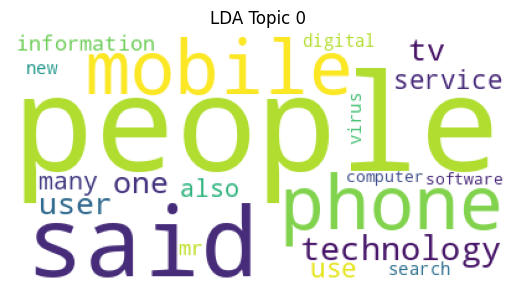

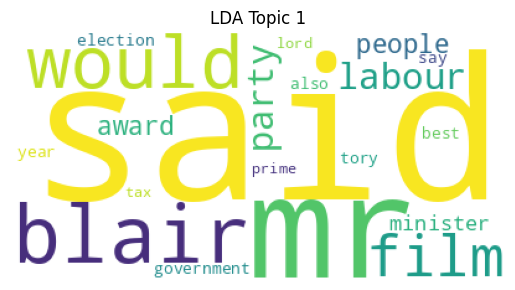

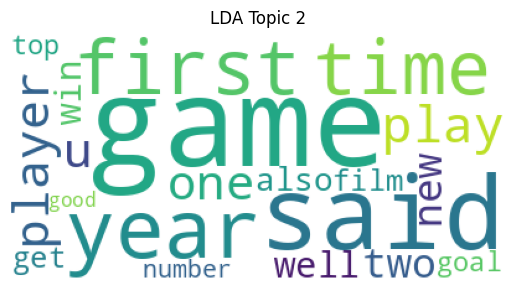

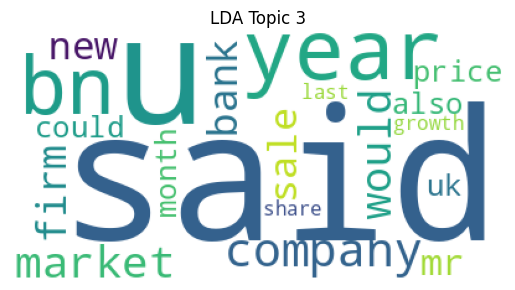

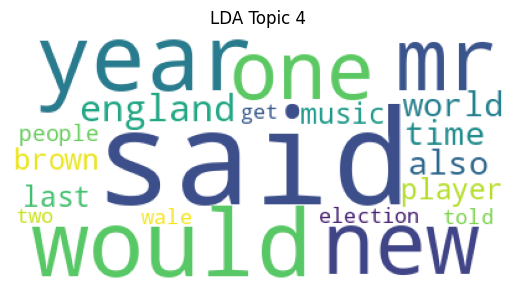

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# LDA
for i in range(5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(i, 20))))
    plt.axis("off")
    plt.title(f"LDA Topic {i}")
    plt.show()


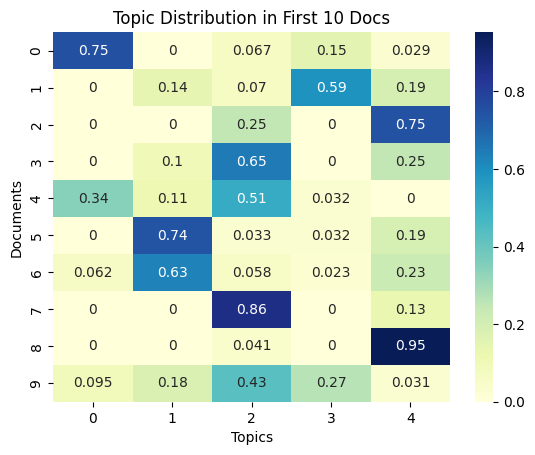

In [ ]:
import seaborn as sns
import numpy as np

topic_dist = [lda_model.get_document_topics(corpus[i]) for i in range(10)]
matrix = np.zeros((10, 5))
for i, dist in enumerate(topic_dist):
    for topic_id, prob in dist:
        matrix[i, topic_id] = prob

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.title("Topic Distribution in First 10 Docs")
plt.show()


In [ ]:
#BERTopic Modeling


from bertopic import BERTopic

docs = df['clean_text'].tolist()
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

topic_model.get_topic_info().head()


2025-07-15 14:17:01,128 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-07-15 14:17:11,196 - BERTopic - Embedding - Completed ✓
2025-07-15 14:17:11,198 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-15 14:17:25,287 - BERTopic - Dimensionality - Completed ✓
2025-07-15 14:17:25,288 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-15 14:17:25,550 - BERTopic - Cluster - Completed ✓
2025-07-15 14:17:25,555 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-15 14:17:25,937 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,375,-1_said_mr_would_year,"[said, mr, would, year, government, minister, ...",[brown target oaps homebuyers gordon brown dou...
1,0,336,0_england_club_game_player,"[england, club, game, player, side, wale, team...",[wilkinson lead england fly half jonny wilkins...
2,1,233,1_mobile_phone_game_technology,"[mobile, phone, game, technology, people, vide...",[gate open biggest gadget fair bill gate opene...
3,2,154,2_film_best_award_oscar,"[film, best, award, oscar, actor, director, st...",[aviator vera take bafta glory hollywood block...
4,3,120,3_music_band_album_song,"[music, band, album, song, best, rock, single,...",[u desire number one u three prestigious gramm...


In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta

# Simulate timestamps if not available
df['date'] = pd.date_range(start='2021-01-01', periods=len(df), freq='D')

In [ ]:
topics_over_time = topic_model.topics_over_time(docs, df['date'])
topic_model.visualize_topics_over_time(topics_over_time)

df['dominant_topic'] = topics
df['topic_name'] = df['dominant_topic'].apply(lambda t: topic_model.get_topic(t)[0][0] if t != -1 else "No topic")

2025-07-15 14:17:26,356 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 2225) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
2225it [00:42, 52.77it/s]


In [ ]:
#Coherence Score for LDA and LSA
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel

# LDA
coherence_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
# print("LDA Coherence Score:", coherence_lda.get_coherence())

# LSA (LSI)
lsi_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=5)
coherence_lsa = CoherenceModel(model=lsi_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
# print("LSA Coherence Score:", coherence_lsa.get_coherence())

from gensim.models.coherencemodel import CoherenceModel

# Prepare BERTopic topics in gensim format
# Get topic-word mapping for all topics (excluding -1 which means no topic assigned)
bertopic_topics = topic_model.get_topics()
valid_topic_ids = [t for t in bertopic_topics.keys() if t != -1]

# Convert to list of words per topic
bertopic_topic_words = []
for topic_id in valid_topic_ids:
    words = [word for word, _ in bertopic_topics[topic_id]]
    bertopic_topic_words.append(words)

# Compute coherence
bertopic_coherence_model = CoherenceModel(
    topics=bertopic_topic_words,
    texts=tokenized_docs,  # from earlier preprocessing
    dictionary=dictionary,  # from LDA prep
    coherence='c_v'
)

# print("BERTopic Coherence Score:", bertopic_coherence_model.get_coherence())



/usr/local/lib/python3.11/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning:

`scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.



In [ ]:
print("Model Coherence Scores:")
print(f"✅ LDA Coherence:      {coherence_lda.get_coherence():.4f}")
print(f"✅ LSA Coherence:      {coherence_lsa.get_coherence():.4f}")
print(f"✅ BERTopic Coherence: {bertopic_coherence_model.get_coherence():.4f}")


Model Coherence Scores:
✅ LDA Coherence:      0.3888
✅ LSA Coherence:      0.3491
✅ BERTopic Coherence: 0.7142


In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
topic_summaries = {}

for topic_id in df['dominant_topic'].unique():
    topic_docs = df[df['dominant_topic'] == topic_id]['text'].tolist()
    combined_text = " ".join(topic_docs[:5])
    if len(combined_text) > 1000:
        combined_text = combined_text[:1000]
    summary = summarizer(combined_text, max_length=120, min_length=40, do_sample=False)
    topic_summaries[topic_id] = summary[0]['summary_text']
    print(f"Topic {topic_id} Summary:\n{summary[0]['summary_text']}\n")



Device set to use cuda:0


Topic 1 Summary:
The way people watch tv will be radically different in five years time. This is according to an expert panel which gathered at the annual consumer electronics show in las vegas. programmes and other content will be delivered to viewers via home networks through cable  satellite  telecoms companies.

Topic 9 Summary:
Former worldcom boss never made accounting decisions, witness says. David myers made comments under questioning by defence lawyers. Prosecutors claim losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.

Topic 0 Summary:
 leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game. tigers boss john wells believes he would better off playing in the backs  at least initially.

Topic 2 Summary:
 ocean s twelve raids box office. crime caper sequel starring george clooney  brad pitt and julia roberts. It took